In [2]:
import itertools
from typing import Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, einsum
import torchvision.transforms as transforms
from einops.layers.torch import Rearrange, Reduce
import torchinfo

import torchmetrics
import sklearn.metrics

import numpy as np

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

from timm.models.layers import DropPath, to_2tuple, trunc_normal_
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import matplotlib.pyplot as plt
from einops import rearrange, repeat, reduce

import time
from EEGDatasets import MotorImgDataset

import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
BATCH_SIZE = 32

motImgDataset = MotorImgDataset("E:/Documents/datasets/MotorIMGTorch")
training_loader, val_loader, test_loader = motImgDataset.get_train_val_test_dataloader([0.8,0.05,0.15], BATCH_SIZE, tbatch_size=32, num_workers=3, pin_memory=True)

In [2]:
# helpers
def exists(val):
    return val is not None

def default(val, d):
    return val if exists(val) else d

def cast_tuple(val, length = 1):
    return val if isinstance(val, tuple) else ((val,) * length)

# helper classes
class PreNormResidual(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x):
        return self.fn(self.norm(x)) + x

class FeedForward(nn.Module):
    def __init__(self, dim, mult = 4, dropout = 0.):
        super().__init__()
        inner_dim = int(dim * mult)
        self.net = nn.Sequential(
            nn.Linear(dim, inner_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

# MBConv
class SqueezeExcitation(nn.Module):
    def __init__(self, dim, shrinkage_rate = 0.25):
        super().__init__()
        hidden_dim = int(dim * shrinkage_rate)

        self.gate = nn.Sequential(
            Reduce('b c h w -> b c', 'mean'),
            nn.Linear(dim, hidden_dim, bias = False),
            nn.SiLU(),
            nn.Linear(hidden_dim, dim, bias = False),
            nn.Sigmoid(),
            Rearrange('b c -> b c 1 1')
        )

    def forward(self, x):
        return x * self.gate(x)

class MBConvResidual(nn.Module):
    def __init__(self, fn, dropout = 0.):
        super().__init__()
        self.fn = fn
        self.dropsample = Dropsample(dropout)

    def forward(self, x):
        out = self.fn(x)
        out = self.dropsample(out)
        return out + x

class Dropsample(nn.Module):
    def __init__(self, prob = 0):
        super().__init__()
        self.prob = prob
  
    def forward(self, x):
        device = x.device

        if self.prob == 0. or (not self.training):
            return x

        keep_mask = torch.FloatTensor((x.shape[0], 1, 1, 1), device = device).uniform_() > self.prob
        return x * keep_mask / (1 - self.prob)

def MBConv(
    dim_in,
    dim_out,
    *,
    downsample,
    expansion_rate = 4,
    shrinkage_rate = 0.25,
    dropout = 0.
):
    hidden_dim = int(expansion_rate * dim_out)
    stride = 2 if downsample else 1

    net = nn.Sequential(
        nn.Conv2d(dim_in, hidden_dim, 1),
        nn.BatchNorm2d(hidden_dim),
        nn.GELU(),
        nn.Conv2d(hidden_dim, hidden_dim, 3, stride = stride, padding = 1, groups = hidden_dim),
        nn.BatchNorm2d(hidden_dim),
        nn.GELU(),
        SqueezeExcitation(hidden_dim, shrinkage_rate = shrinkage_rate),
        nn.Conv2d(hidden_dim, dim_out, 1),
        nn.BatchNorm2d(dim_out)
    )

    if dim_in == dim_out and not downsample:
        net = MBConvResidual(net, dropout = dropout)

    return net

class RelPosBias(nn.Module):
    r"""Relative position bias module.
    Important: when only w1 is given, 1d embedding is used.
    """
    def __init__(self,dim,w1,w2 = 0):
        super().__init__()
        #do 2d embedding
        if(w2 != 0):
            self.rel_pos_bias = nn.Embedding((2 * w1 - 1)*(2 * w2 - 1), dim)

            pos1 = torch.arange(w1)
            pos2 = torch.arange(w2)
            grid = torch.stack(torch.meshgrid(pos1, pos2, indexing = 'ij'))
            #print(grid.shape)
            grid = rearrange(grid, 'c i j -> (i j) c')
            #print("grid: ", grid)

            #subtract each entry from each other entry to get distance
            rel_pos = rearrange(grid, 'i ... -> i 1 ...') - rearrange(grid, 'j ... -> 1 j ...')
            #print("rel_pos: ", rel_pos)

            #we want to a unique index between 0 and (2 * w1 - 1)*(2 * w2 - 1) for 
            #each pair, so we have to add 2wy-1 to the x difference
            rel_pos_indices = (rel_pos * torch.tensor([w2, 1]))
            #print("rel_pos_ind: ", rel_pos_indices)
            rel_pos_indices = rel_pos_indices.sum(dim = -1)
            rel_pos_indices += w1*w2-1
            #print("summed_ind: ", rel_pos_indices)
            self.register_buffer('rel_pos_indices', rel_pos_indices, persistent = False)
        #just do 1d embedding
        else:
            self.rel_pos_bias = nn.Embedding(2 * w1 - 1, dim)
            pos = [torch.arange(0, (-1) * w1, -1) + i for i in range(w1)]
            pos = torch.stack(pos)
            rel_pos_indices = pos + w1 - 1
            self.register_buffer('rel_pos_indices', rel_pos_indices, persistent = False)
        
    def forward(self,x):
        #print("ind_shape: ", self.rel_pos_indices.shape)
        bias = self.rel_pos_bias(self.rel_pos_indices)
        bias = rearrange(bias, "w h c -> c w h")
        #print(f"bias shape: {bias.shape}")
        return x + bias

class Attention(nn.Module):
    def __init__(
        self,
        dim,
        dim_head = 4,
        dropout = 0.,
        window_size = 7
    ):
        super().__init__()
        assert (dim % dim_head) == 0, 'dimension should be divisible by dimension per head'

        window_size = cast_tuple(window_size,2)
        assert len(window_size)<3
        w1,w2 = window_size

        self.heads = dim // dim_head
        self.scale = dim_head ** -0.5

        self.to_qkv = nn.Linear(dim, dim * 3, bias = False)

        self.attend = nn.Sequential(
            nn.Softmax(dim = -1),
            nn.Dropout(dropout)
        )

        self.to_out = nn.Sequential(
            nn.Linear(dim, dim, bias = False),
            nn.Dropout(dropout)
        )

        #relative positional bias
        self.rel_pos_bias = RelPosBias(self.heads,w1,w2)

    def forward(self, x):
        batch, height, width, window_height, window_width, _, device, h = *x.shape, x.device, self.heads

        # flatten to 1d data with dimension d, so basically image is now like big time signal
        x = rearrange(x, 'b x y w1 w2 d -> (b x y) (w1 w2) d')

        # project for queries, keys, values
        q, k, v = self.to_qkv(x).chunk(3, dim = -1)

        # split heads
        q, k, v = map(lambda t: rearrange(t, 'b n (h d ) -> b h n d', h = h), (q, k, v))

        # scale
        q = q * self.scale

        # simalarity matrix
        sim = einsum('b h i d, b h j d -> b h i j', q, k)

        # add positional bias
        #print("sim_shape before Pos: ", sim.shape)
        sim = self.rel_pos_bias(sim)
        #print("sim after Pos: ", sim)

        # attention
        attn = self.attend(sim)

        # aggregate
        out = einsum('b h i j, b h j d -> b h i d', attn, v)

        # merge heads
        out = rearrange(out, 'b h (w1 w2) d -> b w1 w2 (h d)', w1 = window_height, w2 = window_width)

        # combine heads out
        out = self.to_out(out)
        return rearrange(out, '(b x y) ... -> b x y ...', x = height, y = width)

class Mlp(nn.Module):
    """ MLP as used in Vision Transformer, MLP-Mixer and related networks
    """

    def __init__(
            self,
            in_features,
            hidden_features=None,
            out_features=None,
            act_layer=nn.GELU):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x

class ConvPosEnc(nn.Module):
    def __init__(self, dim, k=3, act=False, normtype=False):
        super(ConvPosEnc, self).__init__()
        self.proj = nn.Conv2d(dim,
                              dim,
                              to_2tuple(k),
                              to_2tuple(1),
                              to_2tuple(k // 2),
                              groups=dim)
        self.normtype = normtype
        if self.normtype == 'batch':
            self.norm = nn.BatchNorm2d(dim)
        elif self.normtype == 'layer':
            self.norm = nn.LayerNorm(dim)
        self.activation = nn.GELU() if act else nn.Identity()

    def forward(self, x, size: Tuple[int, int]):
        B, N, C = x.shape
        H, W = size
        assert N == H * W

        feat = x.transpose(1, 2).view(B, C, H, W)
        feat = self.proj(feat)
        if self.normtype == 'batch':
            feat = self.norm(feat).flatten(2).transpose(1, 2)
        elif self.normtype == 'layer':
            feat = self.norm(feat.flatten(2).transpose(1, 2))
        else:
            feat = feat.flatten(2).transpose(1, 2)
        x = x + self.activation(feat)
        return x

class ChannelAttention(nn.Module):

    def __init__(self, dim, num_heads=8, qkv_bias=False):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.proj = nn.Linear(dim, dim)

        #print("num_heads, head_dim: ", self.num_heads, head_dim)
        #relative positional bias
        self.rel_pos_bias = RelPosBias(self.num_heads,head_dim)

    def forward(self, x):
        #signal is alreday flattened
        B, N, C = x.shape

        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        k = k * self.scale
        
        '''changes: einsum and first mult q, k and not k, v'''
        #print("q-shape, k-shape: ", q.shape, k.shape)
        sim = einsum("b h p g, b h p c -> b h g c", q, k)
        #print("sim_shape before attn: ", sim.shape)
        sim = self.rel_pos_bias(sim)
        #print("sim after attn: ", sim)
        sim = sim.softmax(dim=-1)
        x = einsum("b h g c, b h p c -> b h g p", sim, v).transpose(-1, -2)
        x = x.transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        return x


class ChannelBlock(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm,
                 ffn=True, cpe_act=False, input_shape=(160,64)):
        super().__init__()

        #relative positional bias
        #self.rel_pos_bias = RelPosBias(input_shape[0],input_shape[1],num_heads)

        self.cpe = nn.ModuleList([ConvPosEnc(dim=dim, k=3, act=cpe_act),
                                  ConvPosEnc(dim=dim, k=3, act=cpe_act)])

        self.ffn = ffn
        self.norm1 = norm_layer(dim)
        self.attn = ChannelAttention(dim, num_heads=num_heads, qkv_bias=qkv_bias)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

        if self.ffn:
            self.norm2 = norm_layer(dim)
            mlp_hidden_dim = int(dim * mlp_ratio)
            self.mlp = Mlp(
                in_features=dim,
                hidden_features=mlp_hidden_dim,
                act_layer=act_layer)

    def forward(self, x):
      r""" forward
      Args:
          x: input of shape (B,N,C)
      """
      size = (x.shape[2],x.shape[3])
      # flatten
      x = rearrange(x, 'b d w1 w2 -> b (w1 w2) d')
      cur = self.norm1(x)
      cur = self.attn(cur)
      x = x + self.drop_path(cur)

      x = self.cpe[1](x, size)
      if self.ffn:
          x = x + self.drop_path(self.mlp(self.norm2(x)))
      x = rearrange(x, "b (w1 w2) d -> b d w1 w2", w1=size[0], w2=size[1])
      return x


In [3]:
class MaxDaViT(nn.Module):
    def __init__(
        self,
        *,
        num_classes,
        dim,
        depth,
        dim_head = 32,
        dim_channel_head = 4,
        dim_conv_stem = None,
        window_size = 7,
        mbconv_expansion_rate = 4,
        mbconv_shrinkage_rate = 0.25,
        dropout = 0.1,
        input_shape = (1, 160, 64)
    ):
        super().__init__()
        assert isinstance(depth, tuple), 'depth needs to be tuple of integers indicating number of transformer blocks at that stage'

        # convolutional stem
        dim_conv_stem = default(dim_conv_stem, dim)

        channels = input_shape[0]

        """!!!changed: stride = 2"""
        self.conv_stem = nn.Sequential(
            nn.Conv2d(channels, dim_conv_stem, 3, stride=1, padding = 1),
            nn.Conv2d(dim_conv_stem, dim_conv_stem, 3, padding = 1)
        )

        # variables

        num_stages = len(depth)

        dims = tuple(map(lambda i: (2 ** i) * dim, range(num_stages)))
        dims = (dim_conv_stem, *dims)
        dim_pairs = tuple(zip(dims[:-1], dims[1:]))

        self.layers = nn.ModuleList([])

        # shorthand for window size for efficient block - grid like attention

        window_size = cast_tuple(window_size,2)
        assert len(window_size)<3
        w1,w2 = window_size

        # iterate through stages
        #print("ind|stage_ind|stage_dim_in|stage_dim|layer_depth")
        for ind, ((layer_dim_in, layer_dim), layer_depth) in enumerate(zip(dim_pairs, depth)):
          for stage_ind in range(layer_depth):
            is_first = stage_ind == 0
            stage_dim_in = layer_dim_in if is_first else layer_dim

            assert layer_dim%dim_channel_head == 0
            channel_head_num = layer_dim//dim_channel_head

            #print("{:>3}|{:>9}|{:>12}|{:>9}|{:>11}".format(ind,stage_ind,stage_dim_in,layer_dim,layer_depth))

            block = nn.Sequential(
                MBConv(
                    stage_dim_in,
                    layer_dim,
                    downsample = is_first,
                    expansion_rate = mbconv_expansion_rate,
                    shrinkage_rate = mbconv_shrinkage_rate
                ),
                Rearrange('b d (x w1) (y w2) -> b x y w1 w2 d', w1 = w1, w2 = w2),  # block-like attention
                PreNormResidual(layer_dim, Attention(dim = layer_dim, dim_head = dim_head, dropout = dropout, window_size = window_size)),
                PreNormResidual(layer_dim, FeedForward(dim = layer_dim, dropout = dropout)),
                Rearrange('b x y w1 w2 d -> b d (x w1) (y w2)'),

                Rearrange('b d (w1 x) (w2 y) -> b x y w1 w2 d', w1 = w1, w2 = w2),  # grid-like attention
                PreNormResidual(layer_dim, Attention(dim = layer_dim, dim_head = dim_head, dropout = dropout, window_size = window_size)),
                PreNormResidual(layer_dim, FeedForward(dim = layer_dim, dropout = dropout)),
                Rearrange('b x y w1 w2 d -> b d (w1 x) (w2 y)')
              )
            self.layers.append(block)

        self.mlp_head = nn.Sequential(
            Reduce('b d h w -> b d', 'mean'),
            nn.LayerNorm(dims[-1]),
            nn.Linear(dims[-1], num_classes)
        )

    def forward(self, x):
      #print(f"input_shape: {x.shape}")
      x = self.conv_stem(x)
      #print(f"conv_stem_out_shape: {x.shape}")
      for stage in self.layers:
        x = stage(x)
        #print("x_shape: ", x.shape)

      return self.mlp_head(x)

'''change num_classes because we just have 4 classes'''
maxDaVit = MaxDaViT(num_classes=5,dim=32,depth=(1,1,2,1),dim_conv_stem=3,window_size=(10,4))
#test_output = maxDaVit(test_image_train)
#print(test_output.shape)

In [4]:
maxDaVit.load_state_dict(torch.load("E:/Documents/JupNotebooks/AIModels/EEG/Trained models/MaxVit11.pt"))

<All keys matched successfully>

0.16719808487312818

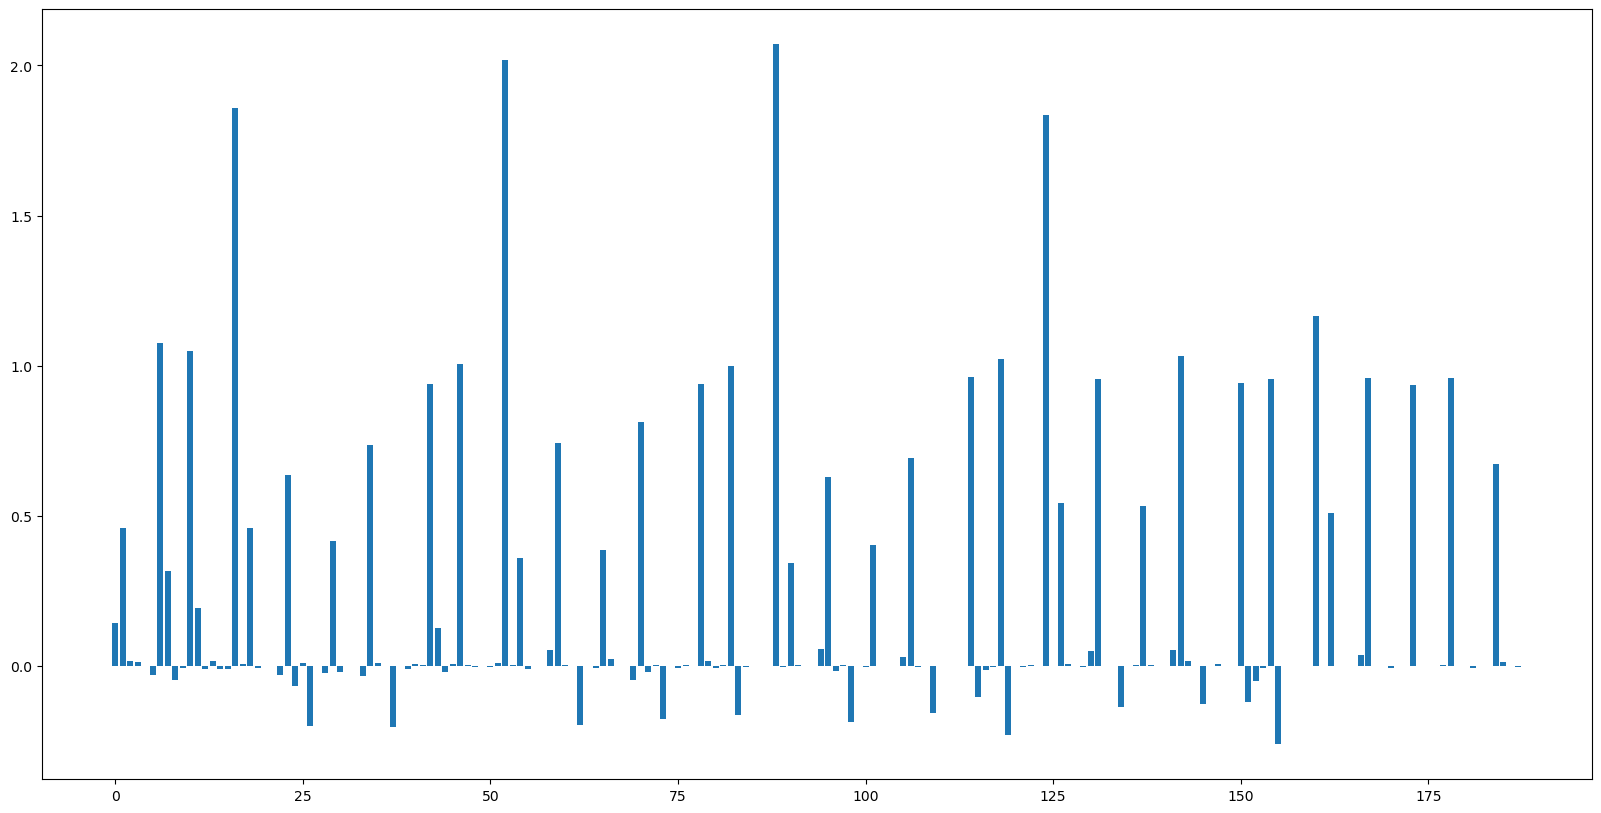

In [5]:
avg_weights = 0
i = 0
mean_weights = []
for param in maxDaVit.parameters():
  flattenened = param.flatten().cpu().detach().numpy()
  mean_weights.append(flattenened.mean())
  avg_weights += flattenened.mean()
  i+=1

fig = plt.figure(figsize=(20,10))
plot = fig.subplots()
plot.bar(np.arange(len(mean_weights)),mean_weights)
avg_weights/i

In [8]:
class_names = ['rest', 'left fist', 'both fists', 'right fist', 'both feet']

maxDaVit.eval()
with torch.no_grad():
    y_pred = maxDaVit(test_x)
    y_pred = torch.argmax(y_pred, dim=1)
    print(class_names[y_pred])
    print(class_names[test_y])

right fist
right fist


In [7]:
torchinfo.summary(maxDaVit, input_size=(32, 1, 160, 64))

Layer (type:depth-idx)                             Output Shape              Param #
MaxDaViT                                           [32, 5]                   --
├─Sequential: 1-1                                  [32, 3, 160, 64]          --
│    └─Conv2d: 2-1                                 [32, 3, 160, 64]          30
│    └─Conv2d: 2-2                                 [32, 3, 160, 64]          84
├─ModuleList: 1-2                                  --                        --
│    └─Sequential: 2-3                             [32, 32, 80, 32]          --
│    │    └─Sequential: 3-1                        [32, 32, 80, 32]          14,688
│    │    └─Rearrange: 3-2                         [32, 8, 8, 10, 4, 32]     --
│    │    └─PreNormResidual: 3-3                   [32, 8, 8, 10, 4, 32]     4,293
│    │    └─PreNormResidual: 3-4                   [32, 8, 8, 10, 4, 32]     8,416
│    │    └─Rearrange: 3-5                         [32, 32, 80, 32]          --
│    │    └─Rearrange: 3-

In [8]:
loss_fn = torch.nn.CrossEntropyLoss()
running_tloss = 0.0
tcorrect = 0.0
# reproducibility
seed = 21
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

target = []
preds  = []
pred_rates = []

maxDaVit.eval()
maxDaVit.to(device)
for i,(x,y) in enumerate(test_loader):
    x = x.to(device)
    y = y.to(device)
    with torch.no_grad():
        y_pred = maxDaVit(x)
        pred_rates.append(y_pred)
        tloss = loss_fn(y_pred, y)
        y_pred = torch.argmax(y_pred, dim=1)
        target.append(y)
        preds.append(y_pred)
    tcorrect += (y_pred == y).type(torch.float).sum().item()
    running_tloss += tloss
    if i%100==0:
        print(f"{i}/1089590 loss: {running_tloss/(i+1)/32}, acc: {tcorrect/(i+1)/32}")

target = torch.cat(target)
pred_rates = torch.cat(pred_rates)
preds = torch.cat(preds)

0/1089590 loss: 0.021220186725258827, acc: 0.875
100/1089590 loss: 0.011820266954600811, acc: 0.8688118811881188
200/1089590 loss: 0.011706656776368618, acc: 0.8676927860696517
300/1089590 loss: 0.011925533413887024, acc: 0.8650332225913622
400/1089590 loss: 0.011867634952068329, acc: 0.8665835411471322
500/1089590 loss: 0.011926835402846336, acc: 0.8662050898203593
600/1089590 loss: 0.0120292529463768, acc: 0.865484608985025
700/1089590 loss: 0.012091263197362423, acc: 0.8649251069900142
800/1089590 loss: 0.011918810196220875, acc: 0.8667681023720349
900/1089590 loss: 0.011908297426998615, acc: 0.8669187014428413
1000/1089590 loss: 0.011826752685010433, acc: 0.8671953046953047
1100/1089590 loss: 0.011837060563266277, acc: 0.8673081289736603
1200/1089590 loss: 0.011725534684956074, acc: 0.8684950041631974
1300/1089590 loss: 0.011680950410664082, acc: 0.8689469638739431
1400/1089590 loss: 0.011715920642018318, acc: 0.8685091006423983
1500/1089590 loss: 0.011773606762290001, acc: 0.86802

In [12]:
# torch.save((target.to('cpu'),preds.to('cpu'),pred_rates.to('cpu')), "Tests/WindowPred.pt")

In [3]:
target, preds, pred_rates = torch.load("Tests/WindowPred.pt")

tensor([[456018,  24938,  32525,  17673,  13457],
        [  4907, 126531,   3041,   1646,   1150],
        [  3394,   2163, 126731,   1590,   1377],
        [  6608,   4022,   3467, 120694,   1288],
        [  7420,   3106,   7443,   1897, 116504]])
[[0.8373279  0.04579048 0.05972153 0.03245068 0.02470938]
 [0.03574577 0.92173374 0.02215261 0.01199053 0.00837734]
 [0.02509334 0.01599202 0.9369783  0.01175557 0.01018077]
 [0.04856003 0.02955636 0.02547785 0.8869407  0.00946509]
 [0.05441079 0.02277627 0.05457945 0.01391068 0.8543228 ]]


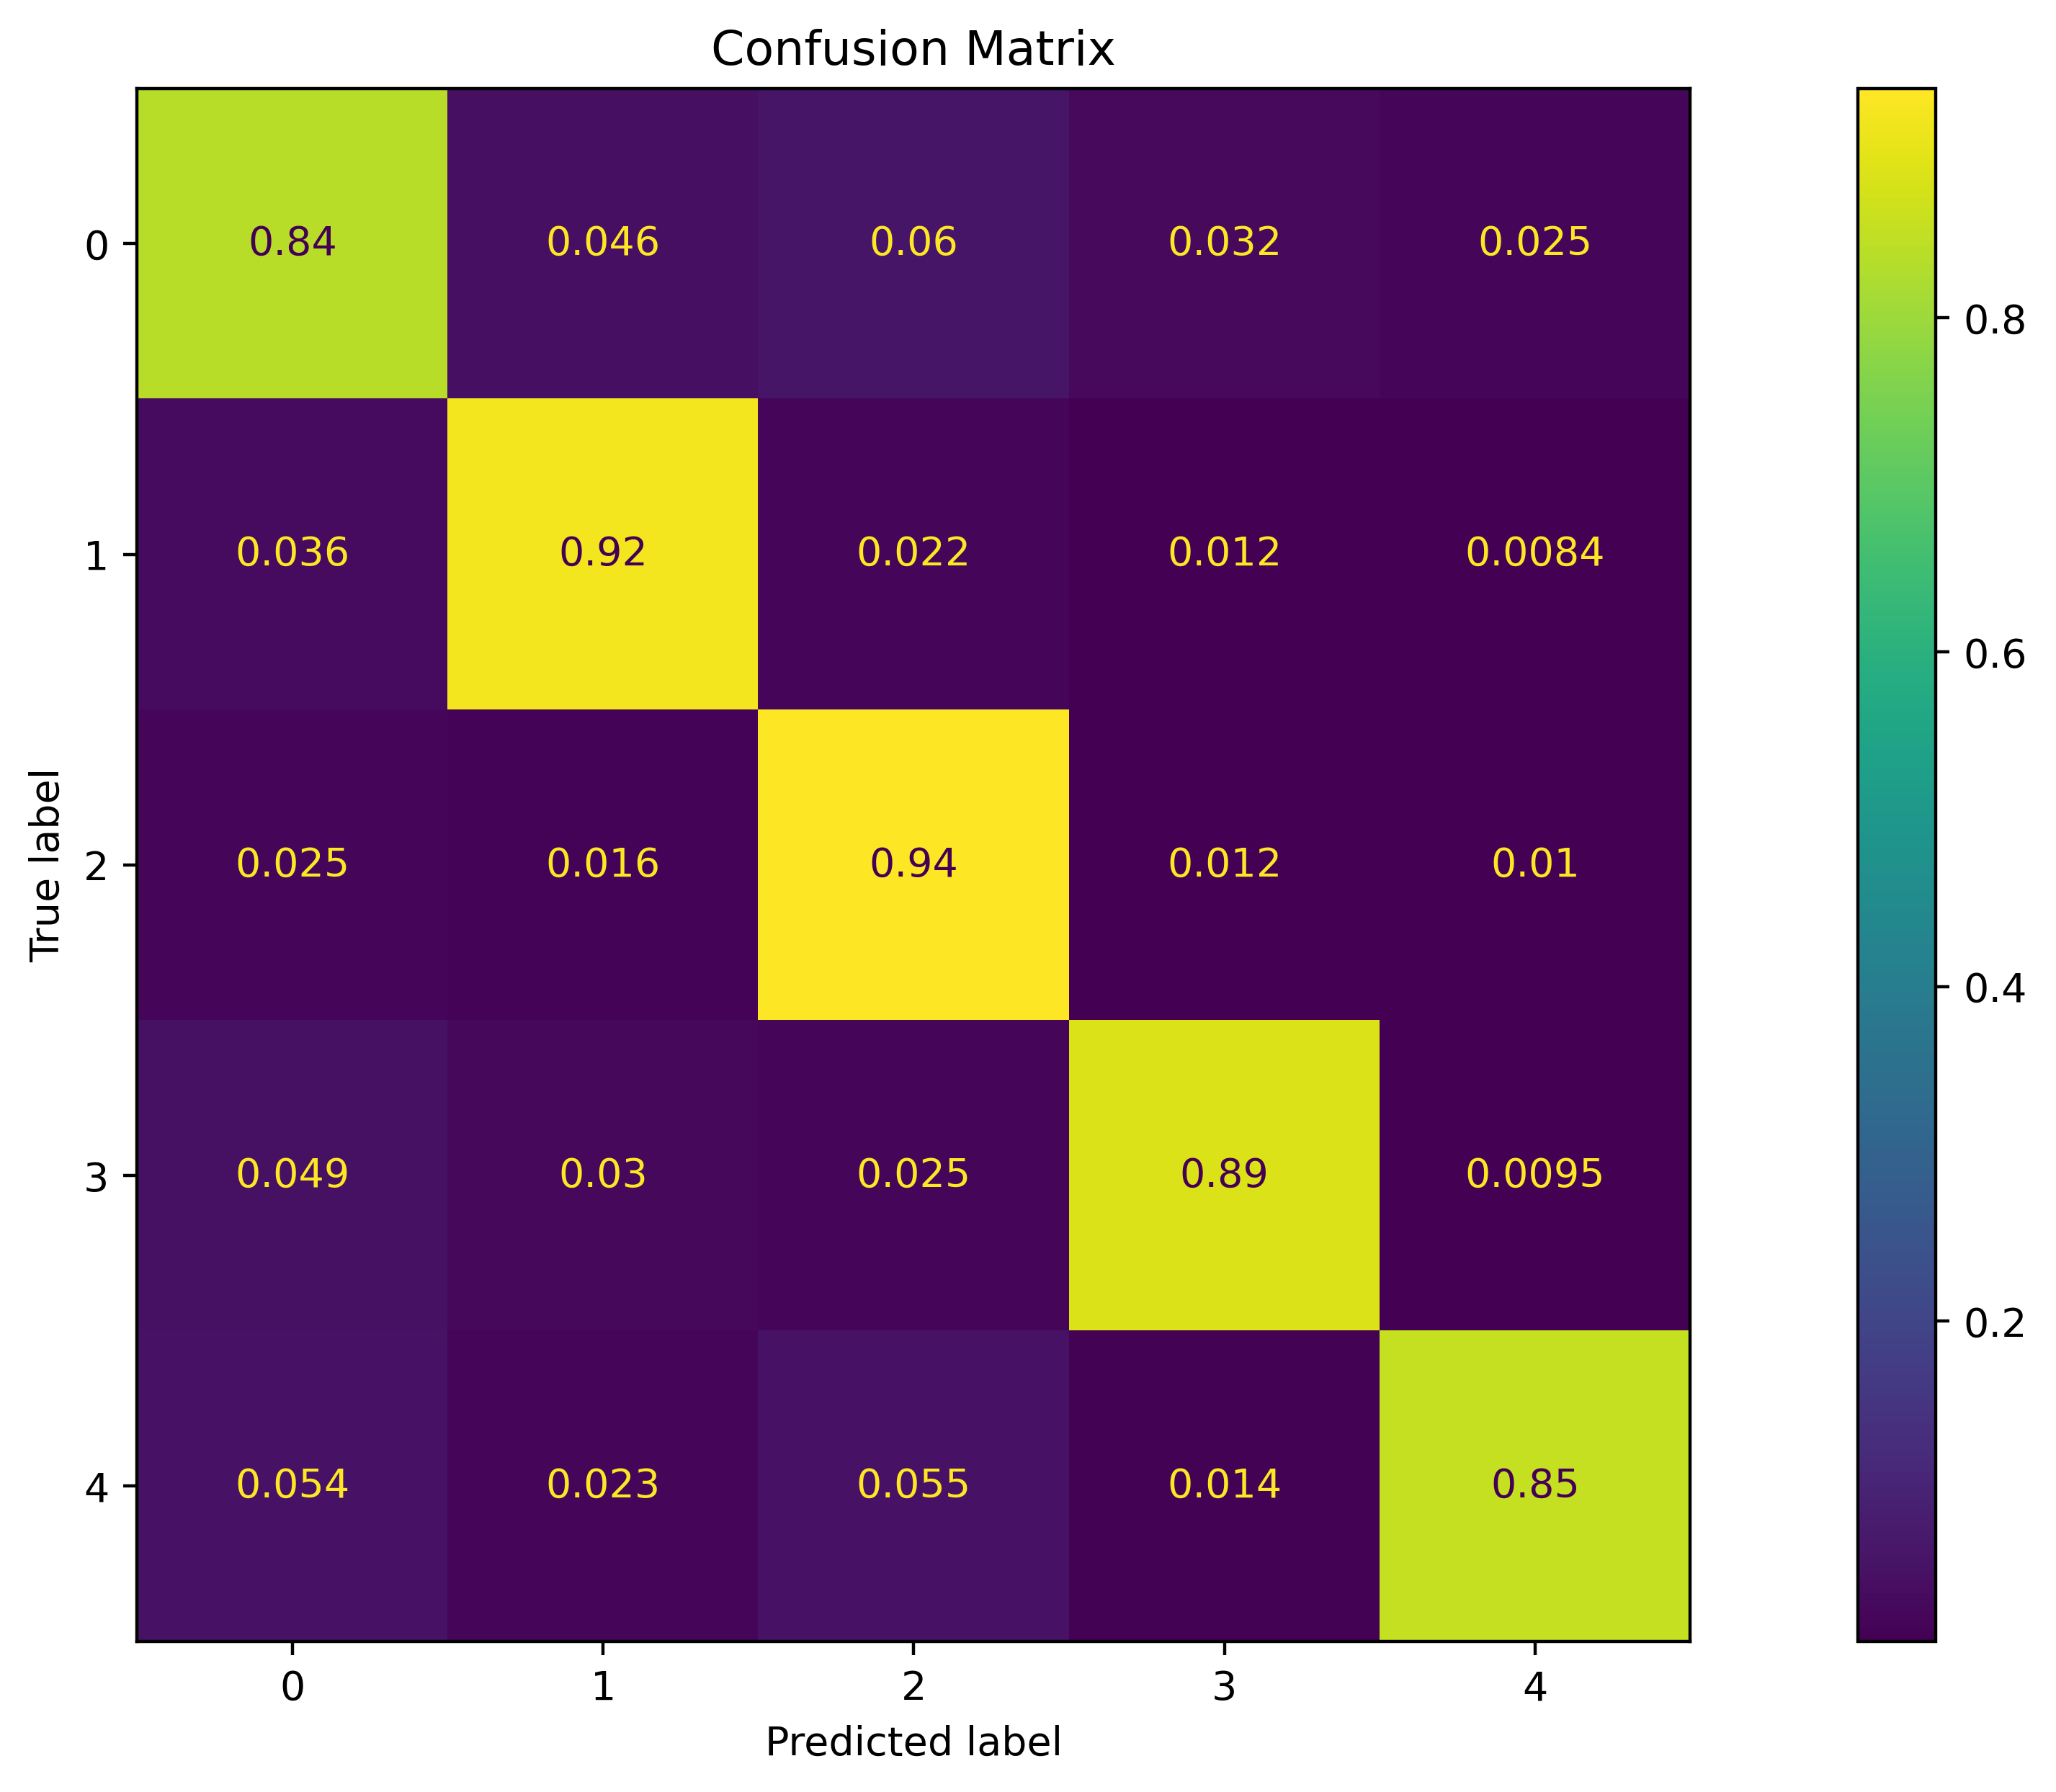

In [4]:
fig = plt.figure(figsize=(15,7),dpi=400)
ax1 = fig.add_subplot(111)

confmat = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=5)
confmat = confmat(preds, target)
confmat_r = confmat.to(torch.float32)
print(confmat)
# calculate relative in each class
for(i,j), val in np.ndenumerate(confmat):
    confmat_r[i,j] = val/confmat[i,:].sum()

print(confmat_r.numpy())

cm_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = confmat_r.numpy(), display_labels = ["0","1","2","3","4"])

ax1.set_title("Confusion Matrix")
cm_display.plot(ax=ax1)


In [8]:
pr_curve = torchmetrics.PrecisionRecallCurve(task="multiclass", num_classes=5)
precision, recall, thresholds = pr_curve(pred_rates, target)

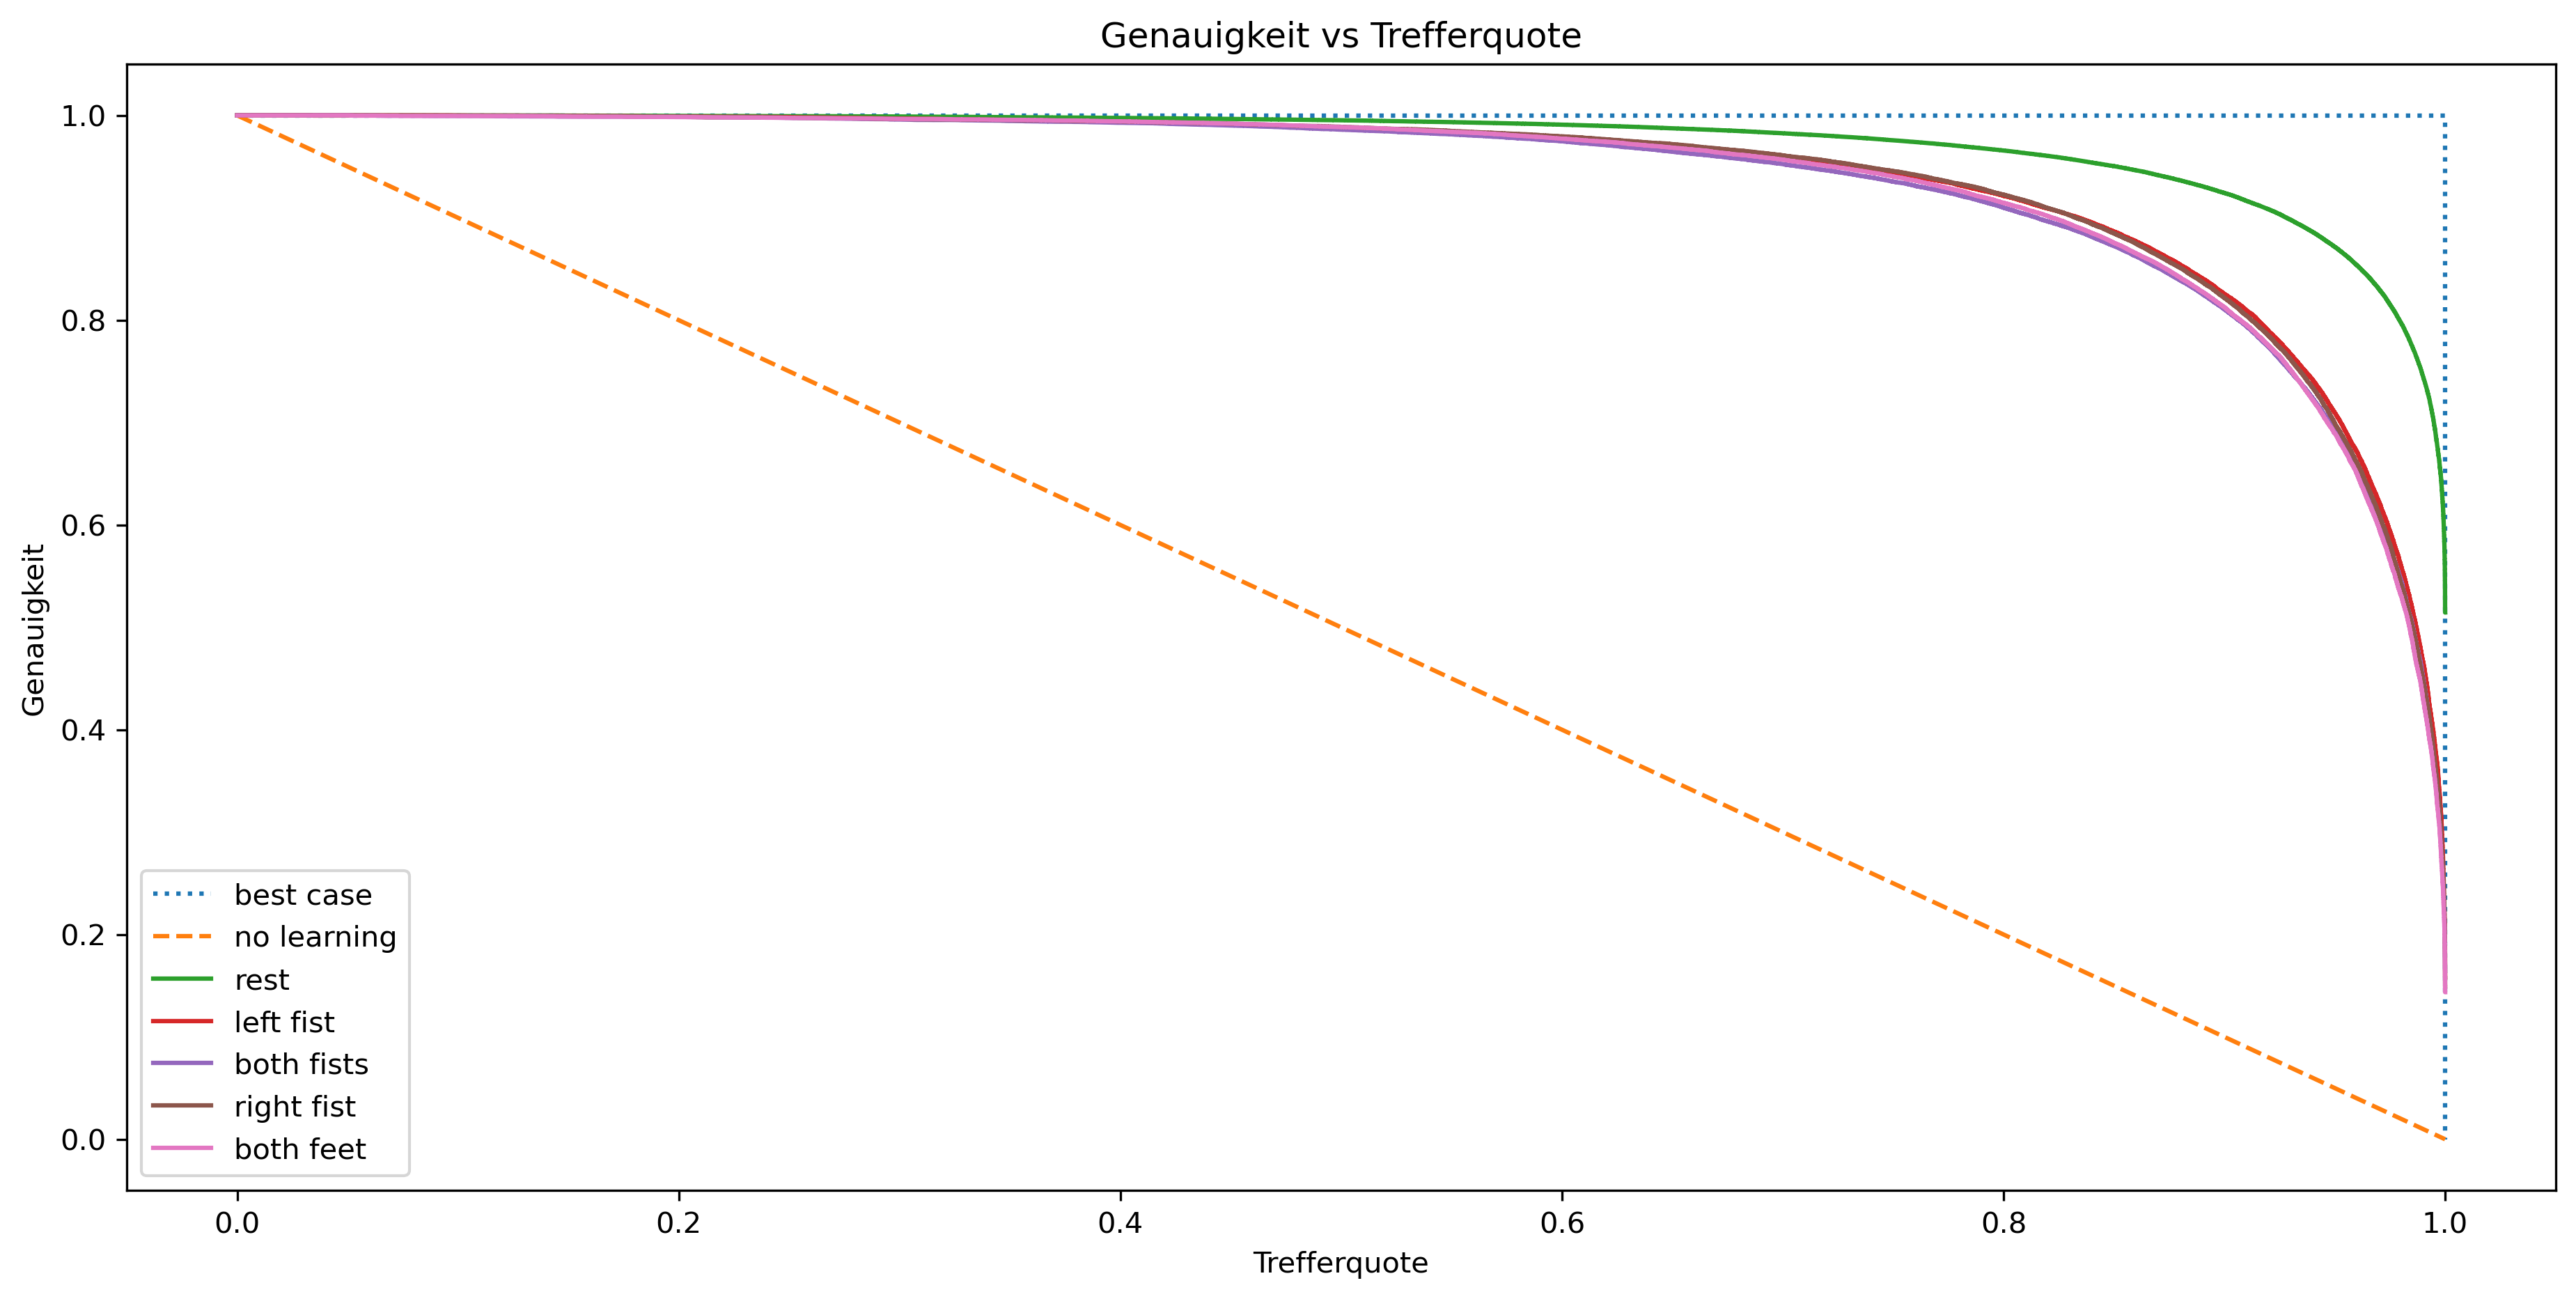

In [12]:
fig = plt.figure(figsize=(15,7), dpi=300)
ax1 = fig.add_subplot(111)


ax1.plot([0,1,1],[1,1,0], ":")
ax1.plot([1,0], "--")
ax1.plot(recall[0], precision[0])
ax1.plot(recall[1], precision[1])
ax1.plot(recall[2], precision[2])
ax1.plot(recall[3], precision[3])
ax1.plot(recall[4], precision[4])

labels = ["best case", "no learning", "rest", "left fist", "both fists", "right fist", "both feet"]

ax1.set_xlabel("Trefferquote")
ax1.set_ylabel("Genauigkeit")
ax1.set_title("Genauigkeit vs Trefferquote")
ax1.legend(labels, loc="lower left")